# Debug $\Delta \phi$ for $H \rightarrow \tau^- \tau^+$

The idea is that if $n=1$ that the angle not well defined and root does some weird stuff and just takes the peak values.

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np")
    return data

In [3]:
#data = load_data("./../src/tree.root")
path = "/afs/cern.ch/work/s/saaumill/public/final-fullsim-inputNN"
data = load_data(f"{path}/Htautau-inputNN-debug-relphi_parent_info_correct.root")

In [4]:
data.keys()

dict_keys(['event_number', 'n_hit', 'n_part', 'jet_p', 'jet_e', 'jet_mass', 'jet_nconst', 'jet_npfcand', 'jet_theta', 'jet_phi', 'recojet_isG', 'recojet_isU', 'recojet_isD', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'pfcand_e', 'pfcand_p', 'pfcand_theta', 'pfcand_phi', 'pfcand_type', 'pfcand_charge', 'pfcand_isEl', 'pfcand_isMu', 'pfcand_isGamma', 'pfcand_isNeutralHad', 'pfcand_isChargedHad', 'jet_nmu', 'jet_nel', 'jet_ngamma', 'jet_nnhad', 'jet_nchad', 'pfcand_erel_log', 'pfcand_phirel', 'pfcand_thetarel', 'pfcand_dptdpt', 'pfcand_detadeta', 'pfcand_dphidphi', 'pfcand_dxydxy', 'pfcand_dzdz', 'pfcand_dxydz', 'pfcand_dphidxy', 'pfcand_dlambdadz', 'pfcand_dxyc', 'pfcand_dxyctgtheta', 'pfcand_phic', 'pfcand_phidz', 'pfcand_phictgtheta', 'pfcand_cdz', 'pfcand_cctgtheta', 'pfcand_dxy', 'pfcand_dz', 'pfcand_btagSip2dVal', 'pfcand_btagSip2dSig', 'pfcand_btagSip3dVal', 'pfcand_btagSip3dSig', 'pfcand_btagJetDistVal', 'pfcand_btagJetDistSig', 'pfcand_mtof', 'pfcand_dndx', 'pf

In [5]:
n_const = data['jet_nconst']

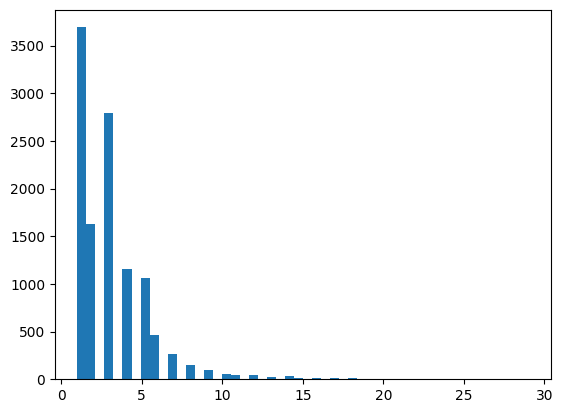

In [6]:
plt.hist(n_const, bins=50)
plt.show()

In [7]:
i_n1 = np.where(n_const == 1)
i_n2 = np.where(n_const == 2)
i_n3 = np.where(n_const == 3)
i_n4 = np.where(n_const == 4)
i_n5 = np.where(n_const == 5)
i_n6 = np.where(n_const == 6)

In [8]:
rel_phi = data['pfcand_phirel']
rel_phi_n1 = rel_phi[i_n1]
rel_phi_n2 = rel_phi[i_n2]
rel_phi_n3 = rel_phi[i_n3]
rel_phi_n4 = rel_phi[i_n4]
rel_phi_n5 = rel_phi[i_n5]
rel_phi_n6 = rel_phi[i_n6]

In [9]:
rel_phi_n1

array([array([0.24497867], dtype=float32),
       array([-2.3561945], dtype=float32),
       array([1.5707964], dtype=float32), ...,
       array([2.1870933], dtype=float32),
       array([1.2490457], dtype=float32),
       array([-2.0344439], dtype=float32)], dtype=object)

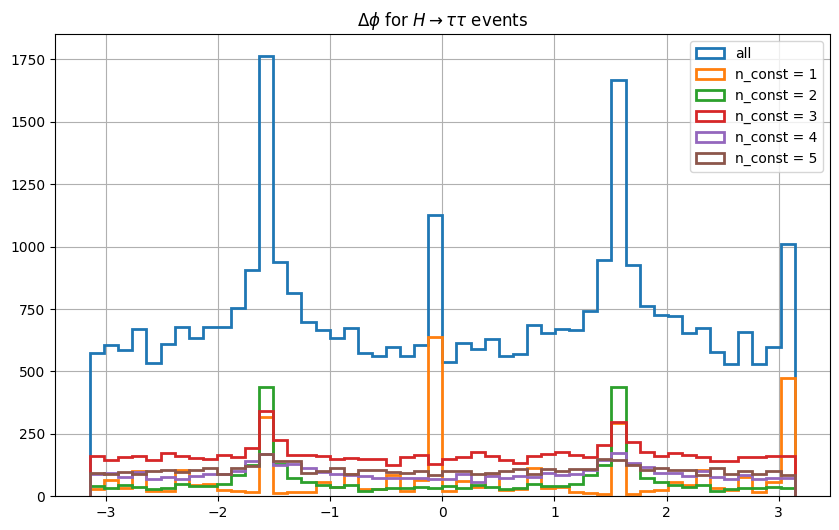

In [10]:
plt.figure(figsize=(10, 6))

plt.hist(np.concatenate(rel_phi), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="all")
plt.hist(np.concatenate(rel_phi_n1), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="n_const = 1")
plt.hist(np.concatenate(rel_phi_n2), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="n_const = 2")
plt.hist(np.concatenate(rel_phi_n3), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="n_const = 3")
plt.hist(np.concatenate(rel_phi_n4), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="n_const = 4")
plt.hist(np.concatenate(rel_phi_n5), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label="n_const = 5")
plt.grid()
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events")
plt.show()

So peaks at 0 and $\pi$ occur for $n=1$ only, the peaks at $\pm \frac{\pi}{2}$ for any number. But more for events with fewer particles per jet.

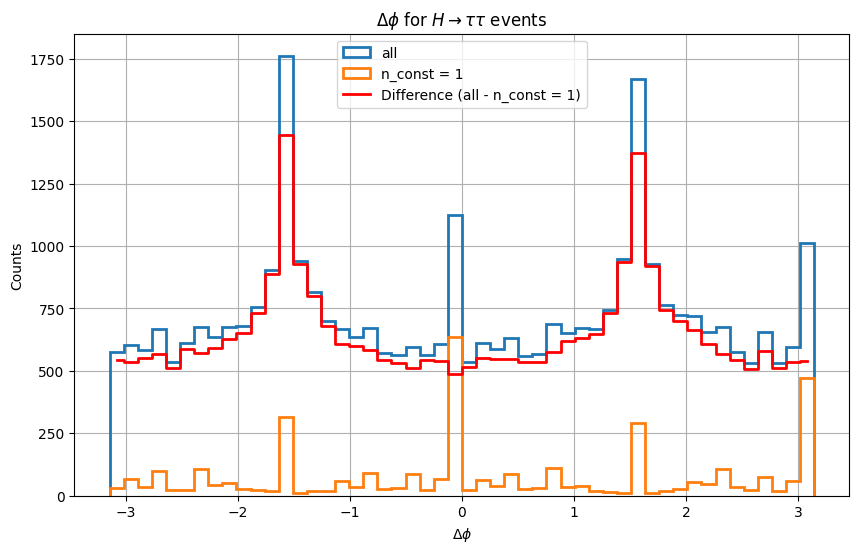

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
# rel_phi and rel_phi_n1 should be provided as lists or arrays of the same length

# Compute histograms
bins = 50
range_bins = (-np.pi, np.pi)

# Compute histograms
hist_all, bin_edges_all = np.histogram(np.concatenate(rel_phi), bins=bins, range=range_bins)
hist_n1, bin_edges_n1 = np.histogram(np.concatenate(rel_phi_n1), bins=bins, range=range_bins)

# Compute the bin centers
bin_centers = (bin_edges_all[:-1] + bin_edges_all[1:]) / 2

# Compute the difference between histograms
hist_diff = hist_all - hist_n1

# Plot the histograms
plt.figure(figsize=(10, 6))

plt.hist(np.concatenate(rel_phi), bins=bins, histtype='step', linewidth=2.0, range=range_bins, label="all")
plt.hist(np.concatenate(rel_phi_n1), bins=bins, histtype='step', linewidth=2.0, range=range_bins, label="n_const = 1")

# Plot the difference histogram
plt.step(bin_centers, hist_diff, where='mid', linewidth=2.0, label="Difference (all - n_const = 1)", color='red')

plt.grid()
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events")
plt.xlabel(r"$\Delta \phi$")
plt.ylabel("Counts")
plt.show()


Ok nice!!!! I can now explain the peaks at 0 and pi but not the once at $\pm \frac{\pi}{2}$. 

New idea: the peaks for charged constituents at pi/2 are due to misclassification to neutral particles. (looking at plot) Ok, shame this is not the explanation. I hoped that the peak at $\pm \frac{\pi}{2}$ might actually be neutral particles that are misidentified but they are not. 

But what about photons?

In [12]:
def get_index_charged_particles(process, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    types = process['pfcand_type']
    if ptype=='cpart':
        num = [-211, -13, -11, 11, 13, 211] 
    elif ptype=='npart':
        num = [2112]
    elif ptype=='photon':
        num = [22]
    elif ptype=='electron':
        num = [11, -11]
    else:
        raise ValueError("Invalid particle type. Choose from cpart, npart, photon, electron.")
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [13]:
def get_value_highest_energy_particle(process, k=3, ptype='cpart'):
    """return the index of the k highest energy charged particle in each event"""
    particles_e = process['pfcand_e']
    mask_chad = get_index_charged_particles(process, ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
    return index_charged

In [14]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
        #elif len(index_list) == 0:
        #    raise ValueError("No charged particles found")
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [15]:
index = get_value_highest_energy_particle(process=data, ptype="photon", k=3)
pid_MC = get_chad_elements(data["pfcand_MCPID"], index)
pid_reco = get_chad_elements(data["pfcand_type"], index)
relphi = get_chad_elements(data["pfcand_phirel"], index)
parent_id = get_chad_elements(data["pfcand_parent_ID"], index)


In [16]:
len(np.concatenate(data["pfcand_parent_ID"]))

36010

In [17]:
len(np.concatenate(data["pfcand_phirel"]))

36010

In [18]:
len(pid_MC[0])

6772

In [19]:
len(pid_reco[0])

6772

5192


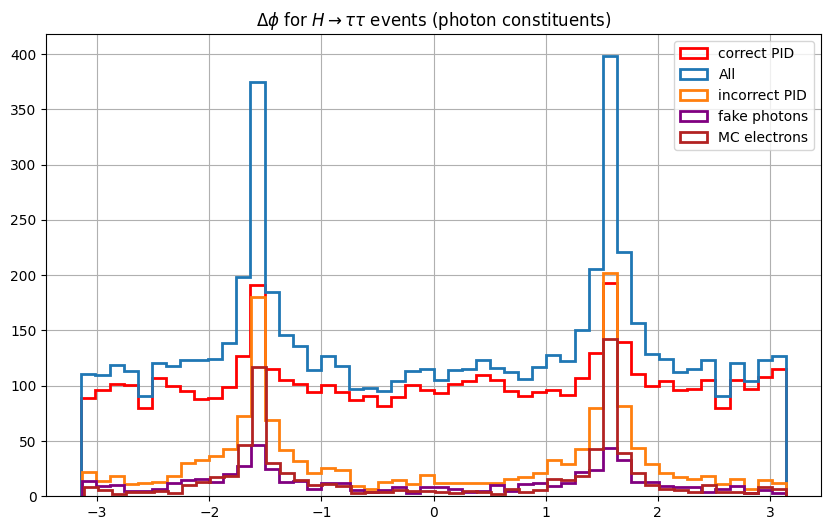

In [20]:
plt.figure(figsize=(10, 6))

ind_corr = np.where(pid_MC[0] == pid_reco[0])
ind_incorr = np.where(pid_MC[0] != pid_reco[0])
ind_noMC = np.where(pid_MC[0] == -999)
ind_fake_e = np.where(abs(pid_MC[0]) == 11)
print(len(ind_corr[0]))

plt.hist(relphi[0][ind_corr], bins=50, histtype='step', linewidth=2.0, density=False, label="correct PID", color='red')
plt.hist(relphi[0], bins=50, histtype='step', linewidth=2.0, density=False, label="All")
plt.hist(relphi[0][ind_incorr], bins=50, histtype='step', linewidth=2.0, density=False, label="incorrect PID")
plt.hist(relphi[0][ind_noMC], bins=50, histtype='step', linewidth=2.0, density=False, label="fake photons", color='purple')
plt.hist(relphi[0][ind_fake_e], bins=50, histtype='step', linewidth=2.0, density=False, label="MC electrons", color='firebrick')
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (photon constituents)")
plt.grid()
plt.show()

Ok so this is not the answer i was looking for? The distribution looks more similar to other decay channels for photons without the incorrect identified particles. But what are they? We see that it's not about the fake photons, electrons yes, but why electrons?? And why do these electrons do to produce the peaks?

In [21]:
pid_MC[0] 

array([ 22,  22,  11, ...,  22, -11,  22], dtype=int32)

In [22]:
pid_reco[0][ind_incorr]

array([22, 22, 22, ..., 22, 22, 22], dtype=int32)

In [23]:
which_instead, n_which_instead = np.unique(pid_MC[0][ind_incorr], return_counts=True)

In [24]:
for n, w in enumerate(which_instead):
    print(f"MC PID {w} \t: {n_which_instead[n]}")

MC PID -999 	: 606
MC PID -321 	: 2
MC PID -211 	: 82
MC PID -13 	: 11
MC PID -11 	: 370
MC PID 11 	: 398
MC PID 13 	: 16
MC PID 130 	: 14
MC PID 211 	: 68
MC PID 310 	: 1
MC PID 321 	: 3
MC PID 2212 	: 8
MC PID 1000010020 	: 1


In [25]:
# what are the parents of the miss-identified photons (MC electrons)?
print("parent PID of miss-identified photons which are MC electrons:")
parent_ids, ids_counts = np.unique(parent_id[0][ind_fake_e], return_counts=True)
for n, w in enumerate(parent_ids):
    print(f"Parent ID {w} \t: {ids_counts[n]}")


parent PID of miss-identified photons which are MC electrons:
Parent ID -211 	: 1
Parent ID -15 	: 169
Parent ID -13 	: 1
Parent ID 15 	: 186
Parent ID 22 	: 400
Parent ID 111 	: 10
Parent ID 211 	: 1


In [26]:
# NEXT TASK:
# group into 3 classes: partents is photon/ tau/ other
# plot the delta phi for the 3 classes

In [27]:
ind_fake_e_parent_photon = np.where(parent_id[0][ind_fake_e] == 22)
ind_fake_e_parent_tau = np.where(abs(parent_id[0][ind_fake_e]) == 15)
condition = (np.abs(parent_id[0][ind_fake_e]) != 22) & (np.abs(parent_id[0][ind_fake_e]) != 15)
ind_fake_e_parent_other = np.where(condition)

In [28]:
print(len(ind_fake_e_parent_photon[0]))
print(len(ind_fake_e_parent_tau[0]))
print(len(ind_fake_e_parent_other[0]))
print("sum should be: ", len(ind_fake_e[0]))

prc_photon = ind_fake_e_parent_photon[0].shape[0] / len(ind_fake_e[0])
prc_tau = ind_fake_e_parent_tau[0].shape[0] / len(ind_fake_e[0])
prc_other = ind_fake_e_parent_other[0].shape[0] / len(ind_fake_e[0])

400
355
13
sum should be:  768


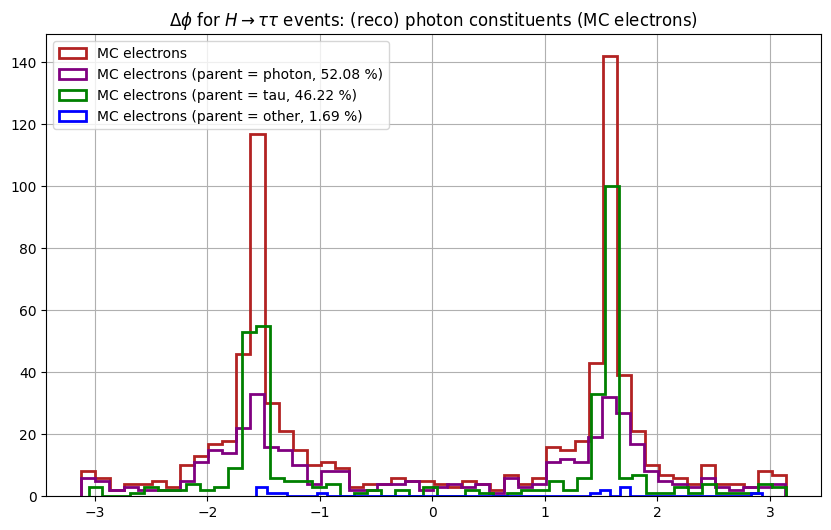

In [29]:
fig = plt.figure(figsize=(10, 6))

#plt.hist(relphi[0], bins=50, histtype='step', linewidth=2.0, density=False, label="All")
plt.hist(relphi[0][ind_fake_e], bins=50, histtype='step', linewidth=2.0, density=False, label="MC electrons", color='firebrick')
plt.hist(relphi[0][ind_fake_e][ind_fake_e_parent_photon], bins=50, histtype='step', linewidth=2.0, density=False, label=f"MC electrons (parent = photon, {prc_photon * 100:.2f} %)", color='purple')
plt.hist(relphi[0][ind_fake_e][ind_fake_e_parent_tau], bins=50, histtype='step', linewidth=2.0, density=False, label=f"MC electrons (parent = tau, {prc_tau * 100:.2f} %)", color='green')
plt.hist(relphi[0][ind_fake_e][ind_fake_e_parent_other], bins=50, histtype='step', linewidth=2.0, density=False, label=f"MC electrons (parent = other, {prc_other * 100:.2f} %)", color='blue')
plt.legend(loc='upper left')
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events: (reco) photon constituents (MC electrons)")
plt.grid()
plt.show()

Mh. Seems like that the reco photons which are actually MC electrons have mostely $\tau$ as a parent at the $\pm \frac{\pi}{2} $ peak...

**Next approach** 

Michele said I should check if I can see such a "structure" in the lab frame as well... He refered to the photon const. picture...

In [30]:
phi_gamma_const = get_chad_elements(data["pfcand_phi"], index)

5192


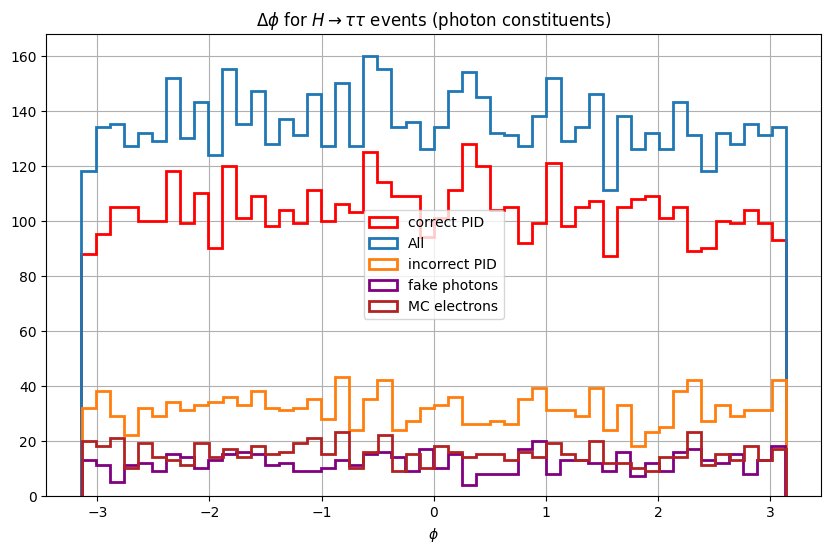

In [31]:
plt.figure(figsize=(10, 6))

ind_corr = np.where(pid_MC[0] == pid_reco[0])
ind_incorr = np.where(pid_MC[0] != pid_reco[0])
ind_noMC = np.where(pid_MC[0] == -999)
ind_fake_e = np.where(abs(pid_MC[0]) == 11)
print(len(ind_corr[0]))

plt.hist(phi_gamma_const[0][ind_corr], bins=50, histtype='step', linewidth=2.0, density=False, label="correct PID", color='red')
plt.hist(phi_gamma_const[0], bins=50, histtype='step', linewidth=2.0, density=False, label="All")
plt.hist(phi_gamma_const[0][ind_incorr], bins=50, histtype='step', linewidth=2.0, density=False, label="incorrect PID")
plt.hist(phi_gamma_const[0][ind_noMC], bins=50, histtype='step', linewidth=2.0, density=False, label="fake photons", color='purple')
plt.hist(phi_gamma_const[0][ind_fake_e], bins=50, histtype='step', linewidth=2.0, density=False, label="MC electrons", color='firebrick')
plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (photon constituents)")
plt.xlabel(r"$\phi$")
plt.grid()
plt.show()

## n=2 for charged, neutral and photon constituents

We see that the peaks at 0 and $\pi$ come from $n=1$ events, still see the peaks at $\pm \pi/2$ for $n>1$ events when looking at all constituents. Let's check this again by diving them into charged, neutral and photons

In [32]:
index_photon = get_value_highest_energy_particle(process=data, ptype="photon", k=3)
index_nhad = get_value_highest_energy_particle(process=data, ptype="npart", k=3)
index_chad = get_value_highest_energy_particle(process=data, ptype="cpart", k=3)

In [33]:
def relphi_n_const_ptype(n, index_ptype):
    # note: we only consider leading particles here (i_n1[0])
    if n==1:
        i_n = i_n1 # one particle in jet
    elif n==2:
        i_n = i_n2 # two particles in jet
    elif n==3:
        i_n = i_n3 # three particles in jet
    elif n==4:
        i_n = i_n4 # four particles in jet
    elif n==5:
        i_n = i_n5
    elif n==6:
        i_n = i_n6
    index_selected = [index_ptype[i] for i in i_n[0]] # considering  all ptype particles in the jet, choose the the ones where n_const = n
    rel_phi_ptype = get_chad_elements(data['pfcand_phirel'][i_n], index_selected) # get their relative phi
    return rel_phi_ptype

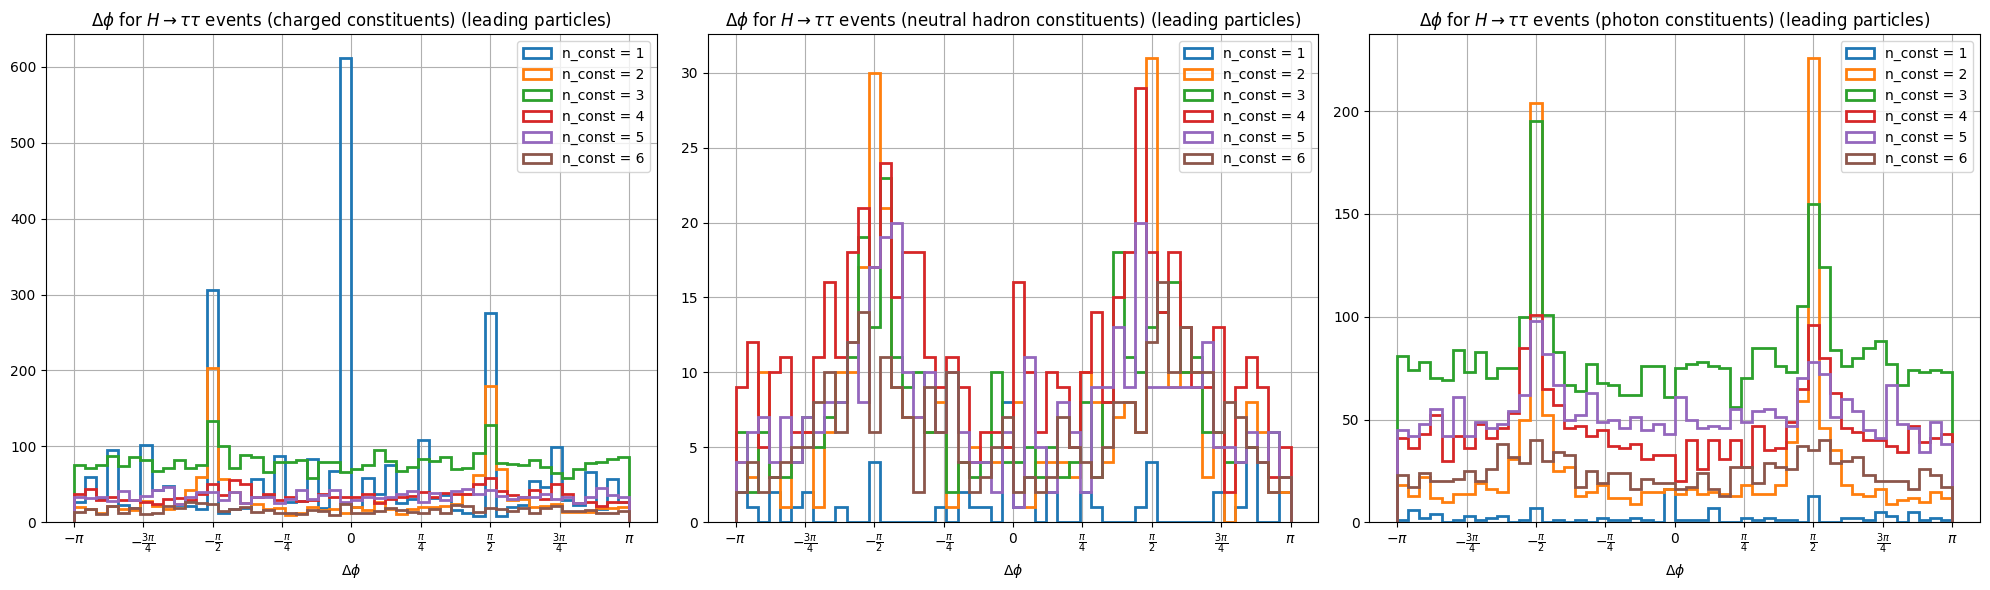

In [34]:

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
xticks = [-np.pi,-3*np.pi/4,  -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
xtick_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$']

for i in range(6):
    rel_phi_n_chad = relphi_n_const_ptype(i+1, index_chad)
    ax[0].hist(np.concatenate(rel_phi_n_chad), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label=f"n_const = {i+1}")
    ax[0].set_title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (charged constituents) (leading particles)")
    ax[0].legend()
    ax[0].grid(True)
    ax[0].set_xlabel(r"$\Delta \phi$")
    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels(xtick_labels)
for i in range(6):
    rel_phi_n_nhad = relphi_n_const_ptype(i+1, index_nhad)
    ax[1].hist(np.concatenate(rel_phi_n_nhad), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label=f"n_const = {i+1}")
    ax[1].set_title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (neutral hadron constituents) (leading particles)")
    ax[1].legend()
    ax[1].grid(True)
    ax[1].set_xlabel(r"$\Delta \phi$")
    ax[1].set_xticks(xticks)
    ax[1].set_xticklabels(xtick_labels)
for i in range(6):
    rel_phi_n_photon = relphi_n_const_ptype(i+1, index_photon)
    ax[2].hist(np.concatenate(rel_phi_n_photon), bins=50, histtype='step', linewidth=2.0, density=False, range=(-np.pi, np.pi), label=f"n_const = {i+1}")
    ax[2].set_title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (photon constituents) (leading particles)")
    ax[2].legend()
    ax[2].grid(True)
    ax[2].set_xlabel(r"$\Delta \phi$")
    ax[2].set_xticks(xticks)
    ax[2].set_xticklabels(xtick_labels)
plt.tight_layout()
plt.show()


NOTE: you only see the leading particles here!!

Okay what do we see here? 

**Charged hadr. const**:

- peak at 0 for $n=1$ -> if one particle only, then undefined phi is set to zero. These are probably either $\tau^- \rightarrow \pi^- + \bar{\nu_{\tau}}$ or $\tau^- \rightarrow e^- + \bar{\nu_{e}} + \nu_{\tau}$ or $\tau^- \rightarrow \mu^- + \bar{\nu_{\mu}} + \nu_{\tau}$
- for higher $n$ the peaks at $\pm \pi/2$ get less. 

**Neutral hadr. const**:
- no sharp peaks as for charged hadrons at 0 or at $\pm \pi/2$. 
- smeered peak around $\pm \pi/2$ for all $n$

**Photon const**:
- $n=1$ does not really exist (makes sense, no decay mode from $\tau$)
- again sharp peaks around $\pm \pi/2$. The higher $n$ the less the peak. 

**General remark**
- no peak at $\Delta \phi = \pi$ - where are these events? Even higher $n$? -> or better idea: from non leading particles!

## seperate by MC PID

In [35]:
# rel_phi 


uniques, ncounts = np.unique(np.concatenate(data["pfcand_MCPID"]), return_counts=True)
sum_part = np.sum(ncounts)
for n, w in enumerate(uniques):
    print(f"MC PID {w} \t: {ncounts[n]}", "\t", f"{(ncounts[n]/sum_part)*100:.2} %")

MC PID -2212 	: 2 	 0.0056 %
MC PID -2112 	: 7 	 0.019 %
MC PID -999 	: 2135 	 5.9 %
MC PID -321 	: 158 	 0.44 %
MC PID -211 	: 6316 	 1.8e+01 %
MC PID -13 	: 1088 	 3.0 %
MC PID -11 	: 2525 	 7.0 %
MC PID 11 	: 2500 	 6.9 %
MC PID 13 	: 1072 	 3.0 %
MC PID 22 	: 13240 	 3.7e+01 %
MC PID 130 	: 124 	 0.34 %
MC PID 211 	: 6331 	 1.8e+01 %
MC PID 310 	: 6 	 0.017 %
MC PID 321 	: 197 	 0.55 %
MC PID 2112 	: 82 	 0.23 %
MC PID 2212 	: 225 	 0.62 %
MC PID 1000010020 	: 1 	 0.0028 %
MC PID 1000020040 	: 1 	 0.0028 %


Okay so let's group into: 
- electrons (13.9%)
- muons (6%)
- photons (37%)
- charged pion 211 (36%)
- no id (5.9%)
- others (1.2%)

In [36]:
ind_MC_e = np.where(np.abs(np.concatenate(data["pfcand_MCPID"])) == 11)
ind_MC_mu = np.where(np.abs(np.concatenate(data["pfcand_MCPID"])) == 13)
ind_MC_photon = np.where(np.abs(np.concatenate(data["pfcand_MCPID"])) == 22)
ind_MC_cpion = np.where(np.abs(np.concatenate(data["pfcand_MCPID"])) == 211)
ind_MC_noID = np.where(np.concatenate(data["pfcand_MCPID"] )== -999)
ind_MC_others = np.where((np.abs(np.concatenate(data["pfcand_MCPID"])) != 11) & (np.abs(np.concatenate(data["pfcand_MCPID"])) != 13) & (np.abs(np.concatenate(data["pfcand_MCPID"])) != 22) & (np.abs(np.concatenate(data["pfcand_MCPID"])) != 211) & (np.concatenate(data["pfcand_MCPID"] )!= -999))

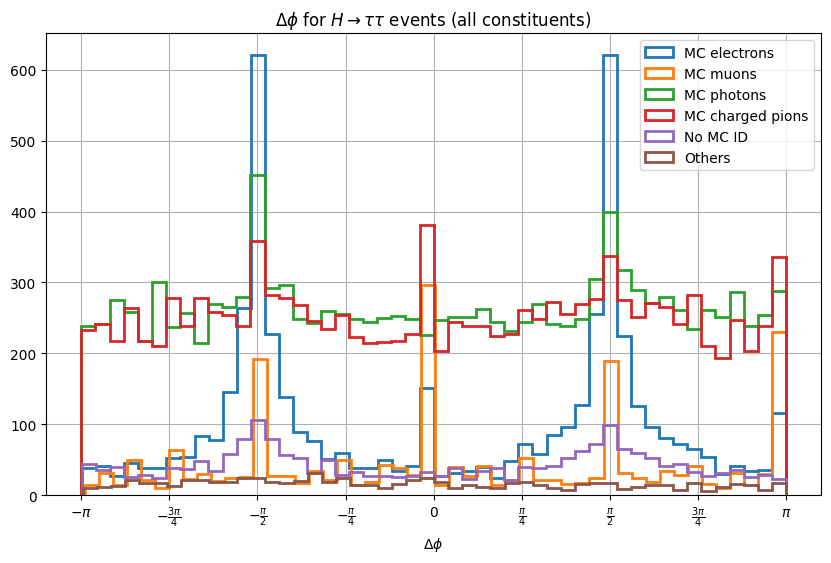

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = 50

plt.hist(np.concatenate(data["pfcand_phirel"])[ind_MC_e], bins=bins, histtype='step', linewidth=2.0, density=False, label="MC electrons")
plt.hist(np.concatenate(data["pfcand_phirel"])[ind_MC_mu], bins=bins, histtype='step', linewidth=2.0, density=False, label="MC muons")
plt.hist(np.concatenate(data["pfcand_phirel"])[ind_MC_photon], bins=bins, histtype='step', linewidth=2.0, density=False, label="MC photons")
plt.hist(np.concatenate(data["pfcand_phirel"])[ind_MC_cpion], bins=bins, histtype='step', linewidth=2.0, density=False, label="MC charged pions")
plt.hist(np.concatenate(data["pfcand_phirel"])[ind_MC_noID], bins=bins, histtype='step', linewidth=2.0, density=False, label="No MC ID")
plt.hist(np.concatenate(data["pfcand_phirel"])[ind_MC_others], bins=bins, histtype='step', linewidth=2.0, density=False, label="Others")

xticks = [-np.pi,-3*np.pi/4,  -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
xtick_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$']
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)


plt.legend()
plt.title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (all constituents)")
plt.grid()
plt.xlabel(r"$\Delta \phi$")
plt.show()

What do we see? 
- peaks at $\Delta \phi = 0$ are as expected from electrons, muons and charged pions due to $\tau^- \rightarrow \pi^- + \bar{\nu_{\tau}}$ and $\tau^- \rightarrow e^- + \bar{\nu_{e}} + \nu_{\tau}$ and $\tau^- \rightarrow \mu^- + \bar{\nu_{\mu}} + \nu_{\tau}$. 
- Why the same particles for $\Delta \phi = \pi$? Can not see a peak in the $n=1$ plot above. 
- very profound peaks for muons at $\pm \pi/2$
- very smooth peaks at $\pm \pi/2$ for electrons?? 

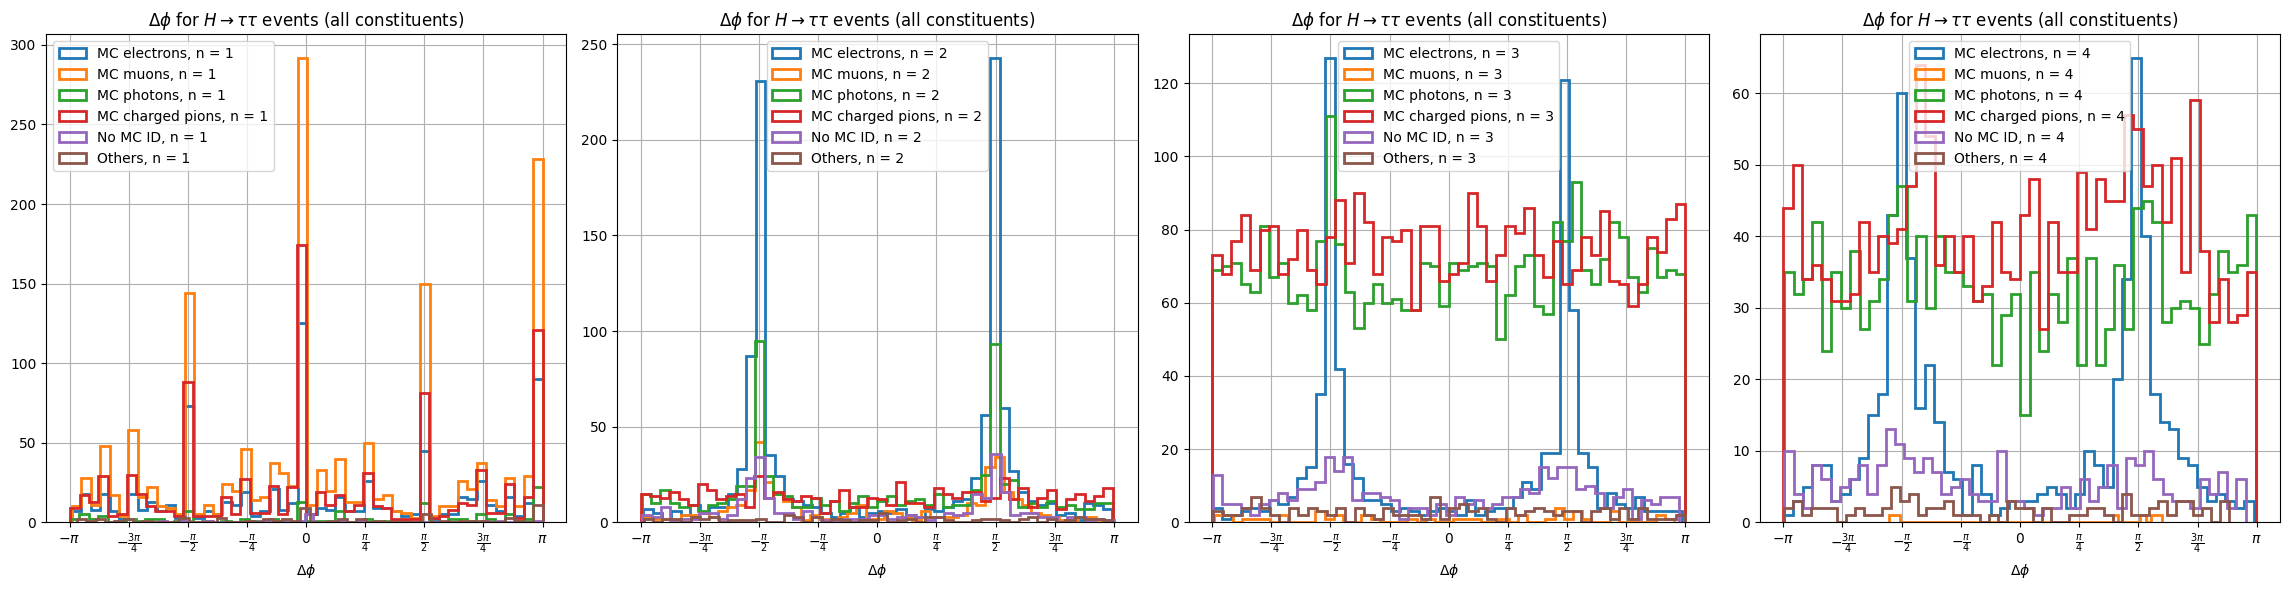

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(23, 6))

bins=50

for i, n in enumerate([i_n1, i_n2, i_n3, i_n4]): #i_n5, i_n6]:
    ind_MC_e = np.where(np.abs(np.concatenate(data["pfcand_MCPID"][n])) == 11)
    ind_MC_mu = np.where(np.abs(np.concatenate(data["pfcand_MCPID"][n])) == 13)
    ind_MC_photon = np.where(np.abs(np.concatenate(data["pfcand_MCPID"][n])) == 22)
    ind_MC_cpion = np.where(np.abs(np.concatenate(data["pfcand_MCPID"][n])) == 211)
    ind_MC_noID = np.where(np.concatenate(data["pfcand_MCPID"][n] )== -999)
    ind_MC_others = np.where((np.abs(np.concatenate(data["pfcand_MCPID"][n])) != 11) & (np.abs(np.concatenate(data["pfcand_MCPID"][n])) != 13) & (np.abs(np.concatenate(data["pfcand_MCPID"][n])) != 22) & (np.abs(np.concatenate(data["pfcand_MCPID"][n])) != 211) & (np.concatenate(data["pfcand_MCPID"][n] )!= -999))

    ax[i].hist(np.concatenate(data["pfcand_phirel"][n])[ind_MC_e], bins=bins, histtype='step', linewidth=2.0, density=False, label=f"MC electrons, n = {i+1}")
    ax[i].hist(np.concatenate(data["pfcand_phirel"][n])[ind_MC_mu], bins=bins, histtype='step', linewidth=2.0, density=False, label=f"MC muons, n = {i+1}")
    ax[i].hist(np.concatenate(data["pfcand_phirel"][n])[ind_MC_photon], bins=bins, histtype='step', linewidth=2.0, density=False, label=f"MC photons, n = {i+1}")
    ax[i].hist(np.concatenate(data["pfcand_phirel"][n])[ind_MC_cpion], bins=bins, histtype='step', linewidth=2.0, density=False, label=f"MC charged pions, n = {i+1}")
    ax[i].hist(np.concatenate(data["pfcand_phirel"][n])[ind_MC_noID], bins=bins, histtype='step', linewidth=2.0, density=False, label=f"No MC ID, n = {i+1}")
    ax[i].hist(np.concatenate(data["pfcand_phirel"][n])[ind_MC_others], bins=bins, histtype='step', linewidth=2.0, density=False, label=f"Others, n = {i+1}")

    xticks = [-np.pi,-3*np.pi/4,  -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$']
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xtick_labels)
    ax[i].legend()
    ax[i].set_title(r"$\Delta \phi$ for $H \rightarrow \tau \tau$ events (all constituents)")
    ax[i].grid()
    ax[i].set_xlabel(r"$\Delta \phi$")

plt.tight_layout()
plt.show()


In [39]:
data["pfcand_p"][i_n1]

array([array([43.63869], dtype=float32),
       array([16.032598], dtype=float32),
       array([30.156448], dtype=float32), ...,
       array([33.594036], dtype=float32),
       array([16.702982], dtype=float32),
       array([0.7547139], dtype=float32)], dtype=object)

In [40]:
data["pfcand_theta"][i_n1]

array([array([0.43358612], dtype=float32),
       array([1.8235475], dtype=float32),
       array([0.6811655], dtype=float32), ...,
       array([1.6089009], dtype=float32),
       array([1.6808738], dtype=float32),
       array([1.7495656], dtype=float32)], dtype=object)

In [41]:
data["pfcand_phi"][i_n1]

array([array([2.959861], dtype=float32),
       array([-0.6914033], dtype=float32),
       array([1.9404112], dtype=float32), ...,
       array([-2.031024], dtype=float32),
       array([1.3198773], dtype=float32),
       array([-1.1253395], dtype=float32)], dtype=object)

In [42]:
for i in range(10):
    print(f"n = {i+1}")
    print("MC PID: ", data["pfcand_MCPID"][i_n1][i], "\t reco pid: ", data["pfcand_type"][i_n1][i], "\t momentum: ", data["pfcand_p"][i_n1][i], data["pfcand_theta"][i_n1][i], (data["pfcand_phi"][i_n1][i])/np.pi, (data["pfcand_phirel"][i_n1][i])/np.pi, "jet: ", data["jet_p"][i_n1][i], data["jet_theta"][i_n1][i], (data["jet_phi"][i_n1][i])/np.pi)
    print("\n")

n = 1
MC PID:  [-13] 	 reco pid:  [-13] 	 momentum:  [43.63869] [0.43358612] [0.942153] [0.07797913] jet:  43.63869 0.43358612 0.9421530307989554


n = 2
MC PID:  [-11] 	 reco pid:  [-11] 	 momentum:  [16.032598] [1.8235475] [-0.22008051] [-0.75] jet:  16.032598 1.8235475 -0.2200805150796245


n = 3
MC PID:  [-211] 	 reco pid:  [-211] 	 momentum:  [30.156448] [0.6811655] [0.61765206] [0.5] jet:  30.156448 0.6811655 0.6176520714239883


n = 4
MC PID:  [22] 	 reco pid:  [22] 	 momentum:  [7.1491575] [2.3996654] [-0.44901764] [-0.7951672] jet:  7.1491575 2.3996654 -0.44901766056501374


n = 5
MC PID:  [13] 	 reco pid:  [13] 	 momentum:  [9.64044] [0.9607966] [0.3528487] [-0.14758362] jet:  9.64044 0.9607966 0.3528487108877204


n = 6
MC PID:  [211] 	 reco pid:  [211] 	 momentum:  [29.879206] [1.7297987] [0.7743023] [0.25] jet:  29.879206 1.7297987 0.7743023462017445


n = 7
MC PID:  [-13] 	 reco pid:  [-13] 	 momentum:  [16.95206] [1.3640593] [0.8099689] [-0.31283295] jet:  16.95206 1.364

In [43]:
import numpy as np

class TLorentzVector:
    def __init__(self, x=0, y=0, z=0):
        self.x = x
        self.y = y
        self.z = z
    
    def set_xyzm(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def set_pthetaphi(self, p, theta, phi):
        self.x = p * np.sin(theta) * np.cos(phi)
        self.y = p * np.sin(theta) * np.sin(phi)
        self.z = p * np.cos(theta)

    def rotate_y(self, theta):
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        x_prime = cos_theta * self.x + sin_theta * self.z
        z_prime = -sin_theta * self.x + cos_theta * self.z
        self.x = x_prime
        self.z = z_prime

    def rotate_z(self, phi):
        cos_phi = np.cos(phi)
        sin_phi = np.sin(phi)
        x_prime = cos_phi * self.x - sin_phi * self.y
        y_prime = sin_phi * self.x + cos_phi * self.y
        self.x = x_prime
        self.y = y_prime

    def phi(self):
        return np.arctan2(self.y, self.x)

    def theta(self):
        return np.arccos(self.z / np.sqrt(self.x**2 + self.y**2 + self.z**2))

    def __str__(self):
        return f"TLorentzVector(x={self.x}, y={self.y}, z={self.z})"

# Example usage:
jet_momentum = np.array([1.0, 2.0, 3.0])  # Example momentum
jet_mass = 4.0  # Example mass
jet_theta = np.pi / 4  # Example theta rotation
jet_phi = np.pi / 6  # Example phi rotation

tlv = TLorentzVector()
print(jet_momentum[0])
tlv.set_xyzm(jet_momentum[0], jet_momentum[1], jet_momentum[2])
tlv.rotate_y(-jet_theta)
tlv.rotate_z(-jet_phi)

print(tlv)


1.0
TLorentzVector(x=-0.22474487139158905, y=2.4391575887554247, z=2.8284271247461903)


In [44]:
for theta in [np.random.uniform(0, np.pi, ) for i in range(10)]:
    for phi in [np.random.uniform(-np.pi, np.pi, ) for i in range(10)]:
        print("theta: ", theta, "\t phi: ", phi)
        tlv_jet = TLorentzVector()
        tlv_jet.set_pthetaphi(5, theta, phi)
        tlv_brem = TLorentzVector()
        tlv_brem.set_pthetaphi(1, theta, phi + 0.1)
        jet_phi = tlv_jet.phi()
        jet_theta = tlv_jet.theta()
        tlv_jet.rotate_z(-tlv_jet.phi())
        tlv_jet.rotate_y(-tlv_jet.theta())
        print("jet :\t", tlv_jet)

        print("brem: \t", tlv_brem)
        tlv_brem.rotate_z(-jet_phi)
        tlv_brem.rotate_y(-jet_theta)
        print("brem after rot: \t", tlv_brem, tlv_brem.phi()/np.pi)

theta:  1.687383699648351 	 phi:  -1.5808867452954858
jet :	 TLorentzVector(x=0.0, y=0.0, z=5.000000000000001)
brem: 	 TLorentzVector(x=0.08917895693010397, y=-0.9891996628704691, z=-0.11632343107821819)
brem after rot: 	 TLorentzVector(x=0.0005771875514263974, y=0.09915568622256138, z=0.9950717646201522) 0.498147131690411
theta:  1.687383699648351 	 phi:  2.801391945839459
jet :	 TLorentzVector(x=8.881784197001252e-16, y=2.220446049250313e-16, z=5.000000000000002)
brem: 	 TLorentzVector(x=-0.9646965329906858, y=0.23628258212983397, z=-0.11632343107821819)
brem after rot: 	 TLorentzVector(x=0.0005771875514263974, y=0.0991556862225614, z=0.9950717646201522) 0.498147131690411
theta:  1.687383699648351 	 phi:  2.536707521438025
jet :	 TLorentzVector(x=0.0, y=4.440892098500626e-16, z=5.000000000000001)
brem: 	 TLorentzVector(x=-0.8692884445779052, y=0.480423208749866, z=-0.11632343107821819)
brem after rot: 	 TLorentzVector(x=0.0005771875514263974, y=0.09915568622256138, z=0.99507176462015

In [45]:
for i in range(50):
    print(f"n = {i+1}")

    print(data["pfcand_parent_ID"][i_n2][i], data["pfcand_parent_index"][i_n2][i], "MC PID: ", data["pfcand_MCPID"][i_n2][i], "\t reco pid: ", data["pfcand_type"][i_n2][i], "\t momentum: ", data["pfcand_p"][i_n2][i], data["pfcand_theta"][i_n2][i], (data["pfcand_phi"][i_n2][i])/np.pi, (data["pfcand_phirel"][i_n2][i])/np.pi, "jet: ", data["jet_p"][i_n2][i], data["jet_theta"][i_n2][i], (data["jet_phi"][i_n2][i])/np.pi)
    # do rotation: 
    tlv = TLorentzVector()
    #print(tlv)
    p = data["jet_p"][i_n2][i]
    theta = data["jet_theta"][i_n2][i]
    phi = data["jet_phi"][i_n2][i]
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    pz =  p*np.cos(theta)
    tlv.set_xyzm(px,py, pz)
    print("Jet phi before rotation: ", tlv.phi(), "(", tlv.phi() / np.pi, "pi)")
    print("Jet theta before rotation: ", tlv.theta(), "(", tlv.theta() / np.pi, "pi)")
    print(tlv)
    tlv.rotate_z(-data["jet_phi"][i_n2][i])
    tlv.rotate_y(-data["jet_theta"][i_n2][i])
    print("Jet phi after rotation: ", tlv.phi(), "(", tlv.phi() / np.pi, "pi)")
    print("Jet theta after rotation: ", tlv.theta(), "(", tlv.theta() / np.pi, "pi)")
    print(tlv)

    # rotation for const
    for j in range(2):
        print("------new const ---")
        tlv_p = TLorentzVector()
        #print(tlv_p)
        p = data["pfcand_p"][i_n2][i][j]
        theta = data["pfcand_theta"][i_n2][i][j]
        phi = data["pfcand_phi"][i_n2][i][j]
        px = p*np.sin(theta)*np.cos(phi)
        py = p*np.sin(theta)*np.sin(phi)
        pz =  p*np.cos(theta)
        tlv_p.set_xyzm(px,py, pz)
        print("const phi before rotation: ", tlv_p.phi(), "(", tlv_p.phi() / np.pi, "pi)")
        print("const theta before rotation: ", tlv_p.theta(), "(", tlv_p.theta() / np.pi, "pi)")
        print(tlv_p)
        tlv_p.rotate_z(-data["jet_phi"][i_n2][i])
        tlv_p.rotate_y(-data["jet_theta"][i_n2][i])
        print("const phi after rotation: ", tlv_p.phi(), "(", tlv_p.phi() / np.pi, "pi)")
        print("const theta after rotation: ", tlv_p.theta(), "(", tlv_p.theta() / np.pi, "pi)")
        print(tlv_p)


    
    
    print("\n")

n = 1
[15 11] [15 18] MC PID:  [11 22] 	 reco pid:  [22 22] 	 momentum:  [14.056631   4.2443166] [0.82359034 0.82406074] [0.72352695 0.7133123 ] [ 0.5044989 -0.4955027] jet:  18.300043 0.8236537 0.7211573272887923
Jet phi before rotation:  2.2655826 ( 0.7211573272887923 pi)
Jet theta before rotation:  0.8236536618552125 ( 0.2621771033599951 pi)
TLorentzVector(x=-8.595306396484375, y=10.313362121582031, z=12.435708045959473)
Jet phi after rotation:  0.0 ( 0.0 pi)
Jet theta after rotation:  0.0 ( 0.0 pi)
TLorentzVector(x=0.0, y=0.0, z=18.3000431060791)
------new const ---
const phi before rotation:  2.273027 ( 0.723526947584842 pi)
const theta before rotation:  0.8235903608307602 ( 0.2621569540181064 pi)
TLorentzVector(x=-6.660627841949463, y=7.872070789337158, z=9.552770614624023)
const phi after rotation:  1.584927 ( 0.5044979211551933 pi)
const theta after rotation:  0.005461666473035119 ( 0.0017385024334056344 pi)
TLorentzVector(x=-0.0010848045349121094, y=0.07676458358764648, z=14.0

In [46]:
data["jet_p"][i_n2][i]*np.sin(data["jet_theta"][i_n2][i]*np.cos(data["jet_phi"][i_n2][i]))

-1.3624984

In [47]:
data["jet_p"][i_n2][i]*np.sin(data["jet_theta"][i_n2][i]*np.sin(data["jet_phi"][i_n2][i]))

-22.274818

In [48]:
data["jet_p"][i_n2][i]*np.cos(data["jet_theta"][i_n2][i])

8.651698

# Now do the same for neutral particles...

Which particles have so similar angles that this happends for neutral particles too? And not only from electron plus brems?

In [60]:
for i in range(200):
    if np.any(data["pfcand_type"][i_n2][i] == 2112):
        print(f"n = {i+1}")
        print(data["pfcand_parent_ID"][i_n2][i], data["pfcand_parent_index"][i_n2][i], "MC PID: ", data["pfcand_MCPID"][i_n2][i], "\t reco pid: ", data["pfcand_type"][i_n2][i], "\t momentum: ", data["pfcand_p"][i_n2][i], data["pfcand_theta"][i_n2][i], (data["pfcand_phi"][i_n2][i])/np.pi, (data["pfcand_phirel"][i_n2][i])/np.pi, "jet: ", data["jet_p"][i_n2][i], data["jet_theta"][i_n2][i], (data["jet_phi"][i_n2][i])/np.pi)
        # do rotation: 
        tlv = TLorentzVector()
        #print(tlv)
        p = data["jet_p"][i_n2][i]
        theta = data["jet_theta"][i_n2][i]
        phi = data["jet_phi"][i_n2][i]
        px = p*np.sin(theta)*np.cos(phi)
        py = p*np.sin(theta)*np.sin(phi)
        pz =  p*np.cos(theta)
        tlv.set_xyzm(px,py, pz)
        print("Jet phi before rotation: ", tlv.phi(), "(", tlv.phi() / np.pi, "pi)")
        print("Jet theta before rotation: ", tlv.theta(), "(", tlv.theta() / np.pi, "pi)")
        print(tlv)
        tlv.rotate_z(-data["jet_phi"][i_n2][i])
        tlv.rotate_y(-data["jet_theta"][i_n2][i])
        print("Jet phi after rotation: ", tlv.phi(), "(", tlv.phi() / np.pi, "pi)")
        print("Jet theta after rotation: ", tlv.theta(), "(", tlv.theta() / np.pi, "pi)")
        print(tlv)

        # rotation for const
        for j in range(2):
            print("------new const ---")
            tlv_p = TLorentzVector()
            #print(tlv_p)
            p = data["pfcand_p"][i_n2][i][j]
            theta = data["pfcand_theta"][i_n2][i][j]
            phi = data["pfcand_phi"][i_n2][i][j]
            px = p*np.sin(theta)*np.cos(phi)
            py = p*np.sin(theta)*np.sin(phi)
            pz =  p*np.cos(theta)
            tlv_p.set_xyzm(px,py, pz)
            print("const phi before rotation: ", tlv_p.phi(), "(", tlv_p.phi() / np.pi, "pi)")
            print("const theta before rotation: ", tlv_p.theta(), "(", tlv_p.theta() / np.pi, "pi)")
            print(tlv_p)
            tlv_p.rotate_z(-data["jet_phi"][i_n2][i])
            tlv_p.rotate_y(-data["jet_theta"][i_n2][i])
            print("const phi after rotation: ", tlv_p.phi(), "(", tlv_p.phi() / np.pi, "pi)")
            print("const theta after rotation: ", tlv_p.theta(), "(", tlv_p.theta() / np.pi, "pi)")
            print(tlv_p)



n = 5
[-15 -15] [15 15] MC PID:  [-11 -11] 	 reco pid:  [ -11 2112] 	 momentum:  [31.819357  4.652187] [2.8573666 2.849519 ] [-0.29354906 -0.29629633] [ 0.09739856 -0.9026022 ] jet:  36.47141 2.8563669 -0.29390766933608614
Jet phi before rotation:  -0.92333823 ( -0.29390768830883385 pi)
Jet theta before rotation:  2.8563668541488294 ( 0.9092098082432661 pi)
TLorentzVector(x=6.189703941345215, y=-8.185259819030762, z=-34.997894287109375)
Jet phi after rotation:  0.0 ( 0.0 pi)
Jet theta after rotation:  0.0 ( 0.0 pi)
TLorentzVector(x=0.0, y=0.0, z=36.471405029296875)
------new const ---
const phi before rotation:  -0.92221165 ( -0.29354908440466043 pi)
const theta before rotation:  2.857366596045925 ( 0.9095280359727438 pi)
TLorentzVector(x=5.389786243438721, y=-7.110783576965332, z=-30.54273223876953)
const phi after rotation:  0.30601877 ( 0.09740879976637994 pi)
const theta after rotation:  0.0010486285559824211 ( 0.0003337888363038372 pi)
TLorentzVector(x=0.03181648254394531, y=0.010

- n=5: from the same tau, two electrons (probably also the same) but reconstruted as electron and neutron. Probably reco went wrong but as from same particle, same angle...
(- n=200: from same tau, prob same pion, but reconstructed as pion and neutron ) # no 0.5 anlge
- n=192: $\pm 0.5 \pi$ angle, from same myon, prob same muon but reco as electron and neutron
- n=11, from the same tau, prob same muon but reco as muon and neutron,  $\pm 0.5 \pi$ angle
- n=41, brems
- n=48, from the same tau, prob same pion but reco as pion and neutron, $\pm 0.5 \pi$ angle
- n=55, angle bigger, but same phenomena
- n=70 same
- n=75 same
- n=76 way ore bigger angles, but same phenomena
- n=78 same

high energy charged particle -> low energy fake neutron